In [1]:
# %conda install -c conda-forge ta-lib -q
# %pip install -r requirements.txt -q

import boto3
import data
import glob
import matplotlib.pyplot as plt
import models
import numpy as np
import os
import pandas as pd
import pypickle
import strategy

from data import * 
from feature_engineering import create_features, normalize_features
from io import StringIO
from IPython.display import display
from sklearn.linear_model import LassoCV
from utils import log

2025-02-11 10:15:16.278098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739268916.314804   29653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739268916.321927   29653 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 10:15:16.350243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system ha

# Read

The data of the selected pairs to trade.

In [2]:
# Define S3 bucket and file path
bucket_name = 'mscfe-capstone-project-bucket'
file_key = 'filtered_data.csv'

# Initialize S3 client
s3 = boto3.client('s3')

# # Read the CSV file from S3
# obj = s3.get_object(Bucket=bucket_name, Key=file_key)
# filtered = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8'))).drop(['Unnamed: 0'], axis=1)
filtered = pd.read_csv('filtered_data.csv').drop(['Unnamed: 0'], axis=1)

display(filtered)

,seriesX,seriesY,correlation,spread_adf_stat,spread_adf_pValue,spread_stationary,series_coint_stat,series_coint_pValue,series_cointegrated
0,GOOG,GOOGL,0.999931,-4.971937,0.000025,True,-4.976339,0.000182,True
1,META,DAXEX_ETF,0.888934,-2.917056,0.043400,True,-3.483091,0.033924,True
2,AMZN,BNBUSDT,0.877059,-3.631203,0.005192,True,-3.545100,0.028601,True
3,AMZN,TRXUSDT,0.814577,-3.869803,0.002269,True,-3.387413,0.043768,True
4,SPY_ETF,AVAXUSDT,0.847292,-3.309927,0.014441,True,-3.698512,0.018406,True
5,SPY_ETF,ETHUSDT,0.862483,-3.428205,0.010034,True,-3.737367,0.016394,True
6,EQQQ_ETF,BNBUSDT,0.886060,-3.816404,0.002744,True,-3.670509,0.019987,True
7,BNBUSDT,ADAUSDT,0.901459,-3.279504,0.015820,True,-3.775562,0.014607,True
8,BNBUSDT,BTCUSDT,0.884604,-2.909961,0.044202,True,-3.393160,0.043116,True
9,BNBUSDT,TRXUSDT,0.933562,-3.656380,0.004770,True,-4.003675,0.007095,True


We have the following pairs to trade:
- GOOG and GOOGL: Google Series A and Google Series C - since both securities depict the performance of the same company, we do not want to consider this pair in our portfolio
- META and DAX ETF
- AMZN and BNBUSDT: Amazon and Binance Coin
- AMZN and TRXUSDT: Amazon and TRON cryptocurrency
- S&P 500 ETF and AVAXUDST: S&P 500 ETF and Avalanche cryptocurrency
- S&P 500 ETF and ETHUDST: S&P 500 ETF and Ethereum cryptocurrency
- EQQQ ETF and BNBUSDT: Nasdaq 100 ETF and Binance coin cryptocurrency
- BNBUSDT and ADAUSDT: Binance Coin and Cardano cryptocurrency
- BNBUSDT and BTCUDST: Binance Coin and Bitcoin
- BNBUSDT and TRXUDST: Binance Coin and TRON cryptocurrency
- BNBUSDT and XRPUDST: Binance Coin and XRP (Ripple) cryptocurrency.

As we can see, the portfolio is composed mostly of cryptocurrencies, but there is also an equity pair (Meta/DAX ETF) as well as equity-cryptocurrency pairs: S&P 500 ETF/Avalanche and S&P 500 ETF/Ethereum. Such a composition, in hindsight, should not come as a surprise because:
- **Cryptocurrency pairs** are driven by similar factors and in this market events on all tradeable coins are still mostly driven by Bitcoin, hence high correlations and time-invariant spreads are fairly expected
- **Equity-cryptocurrency pairs**: S&P 500 ETF against Avalanche and Ethereum reflect the increasing interest in and integration of the traditional financial markets and digital assets, while Amazon against Binance coin and TRON may capture the relationship between large-cap technology firms and the broader crypto ecosystem - AWS is widely used in the blockchain infrastructure and Binance Coin is tied to one of the largest cryptocurrency exchanges
- The **equity-equity pair** Meta/DAX ETF suggests a potential macroeconomic link: Meta is a global tech giant while DAX represents the broader European market; hence these two correlating may be drien by similar trends and/or risk sentiments.

In [3]:
print('********************')
pairs = filtered['seriesX'].iloc[1:] + ' ' + filtered['seriesY'].iloc[1:]
print('Trading pairs:')
for p in pairs:
    print(p)
print('********************')

unique_tickers = pd.concat([filtered['seriesX'].iloc[1:], filtered['seriesY'].iloc[1:]]).drop_duplicates()
print('Unique tickers:')
for ut in unique_tickers:
    print(ut)
print('********************')

# Preview the source data
file_key = 'df_full.csv'
# df_full = pd.read_csv('df_full.csv').drop(['Unnamed: 0'], axis=1)
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df_full = pd.read_csv(StringIO(obj['Body'].read().decode('utf-8'))).drop(['Unnamed: 0'], axis=1)
display(df_full.sample(5))

********************
Trading pairs:
META DAXEX_ETF
AMZN BNBUSDT
AMZN TRXUSDT
SPY_ETF AVAXUSDT
SPY_ETF ETHUSDT
EQQQ_ETF BNBUSDT
BNBUSDT ADAUSDT
BNBUSDT BTCUSDT
BNBUSDT TRXUSDT
BNBUSDT XRPUSDT
********************
Unique tickers:
META
AMZN
SPY_ETF
EQQQ_ETF
BNBUSDT
DAXEX_ETF
TRXUSDT
AVAXUSDT
ETHUSDT
ADAUSDT
BTCUSDT
XRPUSDT
********************


,OpenTime,Open,High,Low,Close,Symbol
85349,2024-10-06 02:25:00,0.52930,0.52930,0.5289,0.52900,XRPUSDT
284667,2024-12-14 07:25:00,0.28480,0.28510,0.2842,0.28430,TRXUSDT
295774,2024-12-18 04:00:00,0.38962,0.38994,0.3894,0.38972,DOGEUSDT
174020,2024-11-05 21:25:00,0.35700,0.35910,0.3570,0.35850,ADAUSDT
300726,2024-12-19 21:15:00,194.86000,195.07000,193.7700,193.95000,SOLUSDT


## Prepare Spreads of the Final Pairs

Once we have the pairs series prepared and aligned in time, we can proceed with spread calculation. Spread between two assets at time $t$ is given directly as the difference between two asset prices, i.e., $$\text{Spread}_{AB, t} = p_{A,t} - p_{B, t}$$ where $p_A$ - price of asset A and $p_B$ - price of asset B.

The next step is to normalize the spread by subtracting the mean and dividing by standard deviation, given as $$\text{Normalized Spread}_t = \frac{\text{Spread}_{AB, t} - \mu_{\text{Spread}_{AB}}}{\sigma_{\text{Spread}_{AB}}}$$

In the base case scenario, a **trading signal** is identified when spread is below -2 or above 2 with the following interpretation:
- $\text{Spread}_{AB, t} < -2$: buy A, sell B
- $\text{Spread}_{AB, t} > 2$: buy B, sell A.

## Additional Considerations

Our trading strategy will work flawlessly if there is always a sequence of events:
1. *Signal* Buy 1 unit of asset A, sell 1 unit of asset B.
2. No action for $n$ periods.
3. *Signal* Sell 1 unit of asset A, buy 1 unit of asset B.

However, in reality, we cannot assume that such a scenario will always occur. Below we have listed some exceptions and how we have handled them:
- A sequence of consecutive trading signals in the next $k$ forecasts: due to the assumption of next-period-opening-price execution (we are unable to open a position at the same tick that feeds the forecast), we must consider the scenario in which we receive more than one trading signal in a row and how we manage the positions. The possibilities are as follows:
    - *First signal entry*: immediate reaction resulting in increasing our exposure on assets A and B until the exposure limit has been reached, which we discuss in the next point; ensures timely reaction to the forecast, but may lead to unnecessarily frequent trades and transaction costs;
    - *Last signal entry*: waiting until the sequence of trading signals is interrupted by a 'No action' forecast; reduces information noise but may execute trades at less favorable prices;
    - *Threshold-based confirmation*: entering a trade only after receiving $m$ trading subsequent signals, e.g., $m=3$; similarly to last signal entry, it helps avoid information noise, but may lead to less favorable execution; this approach 
- Risk management with respect to portfolio asset allocation: having up to 10 unique assets (assuming all trading pairs have generated signals within the same time frame), we must take certain measures to ensure diversification and avoid overexposure to a single asset by assuming that we limit the exposure to any single asset to **25%** of the total portfolio value.
- Trending spread instead of mean reversion: we can forcefully close the position if the spread does not generate an opposite trading signal within $X$ periods
- Conflicting trading signals: it is possible that while on the pair A-B there is a long/short signal, on the pair A-C there is a short/long signal and the position on A would net to 0. Such a situation can be observed in the Forex market and we are allowing it in this project.

# Benchmark Portfolio

Before we train the models of interest, we must first create a baseline portfolio. We have decided to use a simple buy-and-hold strategy, as frequently seen in academic literature and in the practitioners' approaches.

The benchmark buy and hold portfolio is composed of the equally weighted unique instruments, as listed above:
- META
- AMZN
- SPY_ETF
- EQQQ_ETF
- BNBUSDT
- DAXEX_ETF
- TRXUSDT
- AVAXUSDT
- ETHUSDT
- ADAUSDT
- BTCUSDT
- XRPUSDT.

Therefore, the portfolio return is given as $r_{BP} = \frac{1}{n}\sum_{i=1}^{n}r_i$ with $r_i = \frac{P_{T,i}-P_{1,i}}{P_{1,i}}$ – $i^{th}$ asset discrete return and $P_{t,i}$ – price of asset $i$ at time $t$, $n=12$ assets in the benchmark portfolio.

In [4]:
asset_returns = []

# Calculate each asset's return
for ticker in unique_tickers:
    sub_df = (df_full[df_full['Symbol']==ticker]
              .sort_values(by='OpenTime')['Close']
              .copy())
    p1 = sub_df.iloc[0]
    pT = sub_df.iloc[-1]
    r_i = (pT-p1)/p1*100
    asset_returns.append({'Symbol': ticker, 'P1': p1, 'PT': pT, 'Return':r_i})

benchmark_return = pd.DataFrame(asset_returns)
display(benchmark_return)
average_return = benchmark_return['Return'].mean()

# Annualize the return
number_of_days = (pd.to_datetime(df_full['OpenTime'].max())
                  - pd.to_datetime(df_full['OpenTime'].min())).days
annualized_return = (1+average_return/100)**(365/number_of_days) - 1

print(f'Benchmark buy-and-hold portfolio return: {round(average_return, 4)}%')
print(f'Annualized return: {round(annualized_return*100, 4)}%')

,Symbol,P1,PT,Return
0,META,593.1400,612.7700,3.309505
1,AMZN,189.0517,225.9400,19.512282
2,SPY_ETF,581.8000,597.4900,2.696803
3,EQQQ_ETF,37990.0000,42967.0000,13.100816
4,BNBUSDT,556.3000,697.9800,25.468273
5,DAXEX_ETF,162.5000,174.0200,7.089231
6,TRXUSDT,0.1566,0.2524,61.174968
7,AVAXUSDT,26.3200,39.0400,48.328267
8,ETHUSDT,2420.2100,3379.6100,39.641188
9,ADAUSDT,0.3521,0.9860,180.034081


Benchmark buy-and-hold portfolio return: 65.1035%
Annualized return: 453.1127%


The benchmark buy-and-hold portfolio in the training period from 04/10/2024 to 20/01/2025 (108 days) generates a return of 70.6246%. After annualizing we get a whopping return of 591.5384%. Such an outstanding portfolio performance is mostly attributed to the cryptocurrency components of our portfolio: BTCUSDT gained 64.41%, ADAUSDT gained 186.68% and XRPUSDT gained 482.17% over the training period However, it is crucial to remember that cryptocurrencies are highly volatile and while in some periods they can generate incredibly high returns, in other periods they can generate even higher losses. In the training period the most important reason for the price increases was the U. S. presidential election: a win by Donal Trump was welcomed enthusiastially in the markets (both cryptocurrency and conventional). Therefore, annualizing cryptocurrency returns bears high risk.

# Model Training

Each pair has its own model trained. First, the models are trained with default hyperparameters. As a next step, we will tune some of them. Given the fact that the objective of this project is not to explore models as such, but finding the optimal model for long/short pair trading portfolio, we shall not focus on all of the hyperparameters, especially for neural networks, known for the multitude of possibly tuneable parameters.

Additionally, we apply the standard 80:20 training-validation split, i.e., the first 80% of the full training set is used for training and the last 20% for validation and later for hyperparameter tuning. The timeline of the train-validation split is then: 04/10/2024 – 30/12/2024 – training set and 30/12/2024 – 20/01/2025 – validation set.

<u>**NOTE**</u> Currently the models add 5 lags of normalized spread to have some features for modeling.

The Technical Analysis features added are:
- EMA(8), EMA(21), EMA(55) - 8-, 21- and 55-period Exponential Moving Average
- MACD(12, 26, 9) – MACD with 12- and 26-period MAs and 9-period signal line
- RSI(14) – 14-period RSI
- BB(20, 2) – 20-period Bollinger Bands with 2 standard deviations
- ATR(14) – 14-period Average True Range
- Stochastic(14, 3, 3) – Stochastic oscillator with 14-period fast %K and 3-period slow %K and %D
- CCI(20) – 20-period Commodity Channel Index
- %R(14) – 14-period Williams %R oscillator.

,META_EMA8,META_EMA21,META_EMA55,META_MACD,META_RSI14,META_BBupper,META_BBmiddle,META_BBlower,META_ATR14,META_StochK14,...,DAXEX_ETF_BBupper,DAXEX_ETF_BBmiddle,DAXEX_ETF_BBlower,DAXEX_ETF_ATR14,DAXEX_ETF_StochK14,DAXEX_ETF_StochD3,DAXEX_ETF_CCI20,DAXEX_ETF_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-30 12:40:00,-0.112015,-0.252482,-0.531448,1.222947,1.690599,-0.262967,-0.234588,-0.198790,-0.459392,1.314240,...,-0.464160,-0.579344,-0.674906,1.140216,-1.478676,-1.436138,-1.803457,-1.397398,0.274508,No action
2024-10-30 12:45:00,-0.061112,-0.218091,-0.506947,1.347383,1.883822,-0.220207,-0.203277,-0.180259,-0.365947,1.314240,...,-0.454816,-0.602047,-0.726982,1.046290,-1.426290,-1.494198,-1.294698,-1.249917,0.359919,No action
2024-10-30 12:50:00,-0.023652,-0.187712,-0.483682,1.421145,1.809052,-0.183612,-0.175700,-0.162827,-0.559904,1.292751,...,-0.456761,-0.620966,-0.761320,1.149427,-1.277946,-1.425712,-0.917759,-0.954954,0.335966,No action
2024-10-30 12:55:00,-0.003625,-0.163879,-0.462794,1.429781,1.488510,-0.155382,-0.155089,-0.150716,-0.608739,1.297948,...,-0.462336,-0.637660,-0.788027,1.023118,-1.073270,-1.287395,-0.733970,-0.821181,0.281800,No action
2024-10-30 13:00:00,0.019626,-0.139024,-0.441350,1.446421,1.594570,-0.122025,-0.136847,-0.148741,-0.681066,1.261997,...,-0.473791,-0.654131,-0.808836,0.874105,-0.885385,-1.102847,-0.604544,-0.720969,0.318883,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.144e-01
  model = cd_fast.enet_coordinate_descent(


Ridge Regression MSE: 0.0026686735800976863
XGBoost MSE: 0.011973466746946252
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step 
LSTM MSE: 0.025823833414276243
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
RNN MSE: 0.02087320873172194
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Transformer MSE: 0.046755603995235845
[pypickle] Pickle file saved: [models/base_ridge_META_DAXEX_ETF.pkl]
[pypickle] Pickle file saved: [models/base_xgb_META_DAXEX_ETF.pkl]
[pypickle] Pickle file saved: [models/base_lstm_META_DAXEX_ETF.pkl]
[pypickle] Pickle file saved: [models/base_rnn_META_DAXEX_ETF.pkl]
[pypickle] Pickle file saved: [models/base_transformer_META_DAXEX_ETF.pkl]


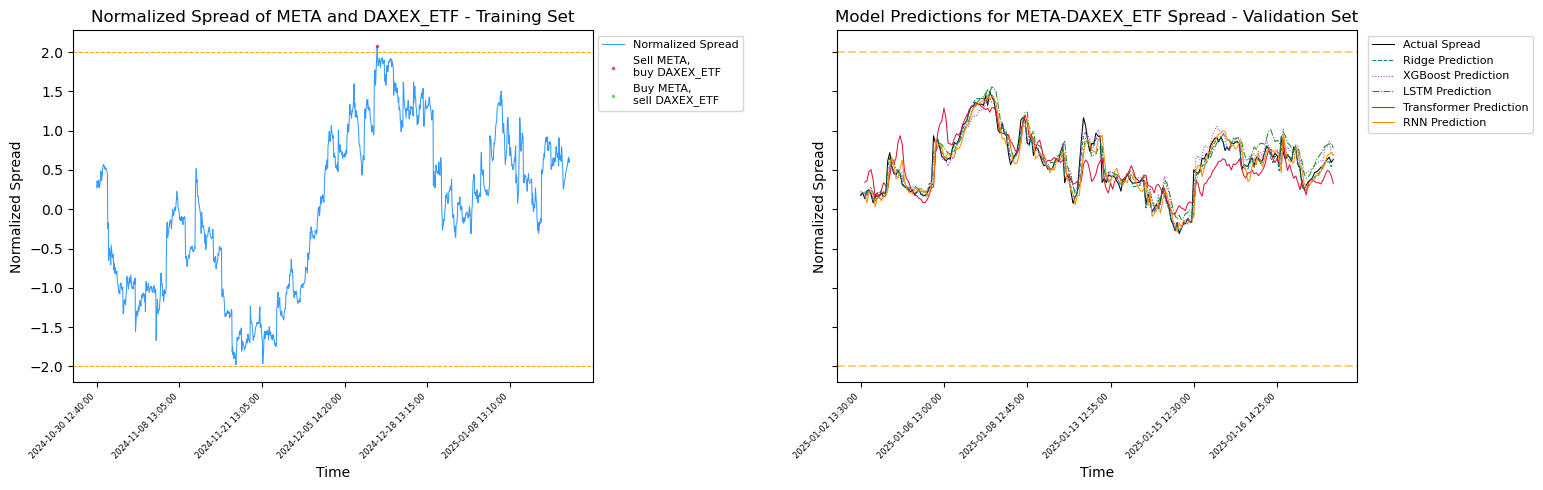

,AMZN_EMA8,AMZN_EMA21,AMZN_EMA55,AMZN_MACD,AMZN_RSI14,AMZN_BBupper,AMZN_BBmiddle,AMZN_BBlower,AMZN_ATR14,AMZN_StochK14,...,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,BNBUSDT_StochD3,BNBUSDT_CCI20,BNBUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-1.391019,-1.376020,-1.345538,-0.474016,-1.382852,-1.406715,-1.372165,-1.329783,-1.308521,-1.394755,...,-1.090324,-1.054688,-1.002540,-0.464262,0.165367,-0.001501,1.034008,0.772447,0.820558,No action
2024-10-14 17:05:00,-1.393486,-1.378174,-1.347258,-0.484739,-1.308223,-1.408894,-1.374627,-1.332518,-1.365904,-1.500015,...,-1.087984,-1.053570,-1.002727,-0.495348,0.332386,0.171164,0.649071,0.462737,0.830704,No action
2024-10-14 17:10:00,-1.395551,-1.380194,-1.348941,-0.490461,-1.329398,-1.412758,-1.377320,-1.334014,-1.425862,-1.502413,...,-1.086201,-1.052173,-1.001755,-0.542537,0.555078,0.363014,0.456366,0.307882,0.835294,No action
2024-10-14 17:15:00,-1.395614,-1.381398,-1.350316,-0.473952,-0.918614,-1.418584,-1.379733,-1.332963,-1.418138,-1.276324,...,-1.085876,-1.051055,-0.999817,-0.549710,0.221040,0.382199,0.051695,-0.156683,0.852325,No action
2024-10-14 17:20:00,-1.397721,-1.383335,-1.351973,-0.479091,-1.242559,-1.421173,-1.381948,-1.334789,-1.387608,-1.315644,...,-1.086469,-1.049751,-0.996529,-0.593016,-0.196508,0.199942,-0.124791,-0.698676,0.853774,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.970e-01, tolerance: 4.441e-01
  model = cd_fast.enet_coordinate_descent(


Ridge Regression MSE: 0.001169661810838656
XGBoost MSE: 0.001934511616195603
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
LSTM MSE: 0.006431885469502982
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
RNN MSE: 0.005054146955509094
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
Transformer MSE: 0.02592535511057436
[pypickle] Pickle file saved: [models/base_ridge_AMZN_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_AMZN_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_AMZN_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_AMZN_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_AMZN_BNBUSDT.pkl]


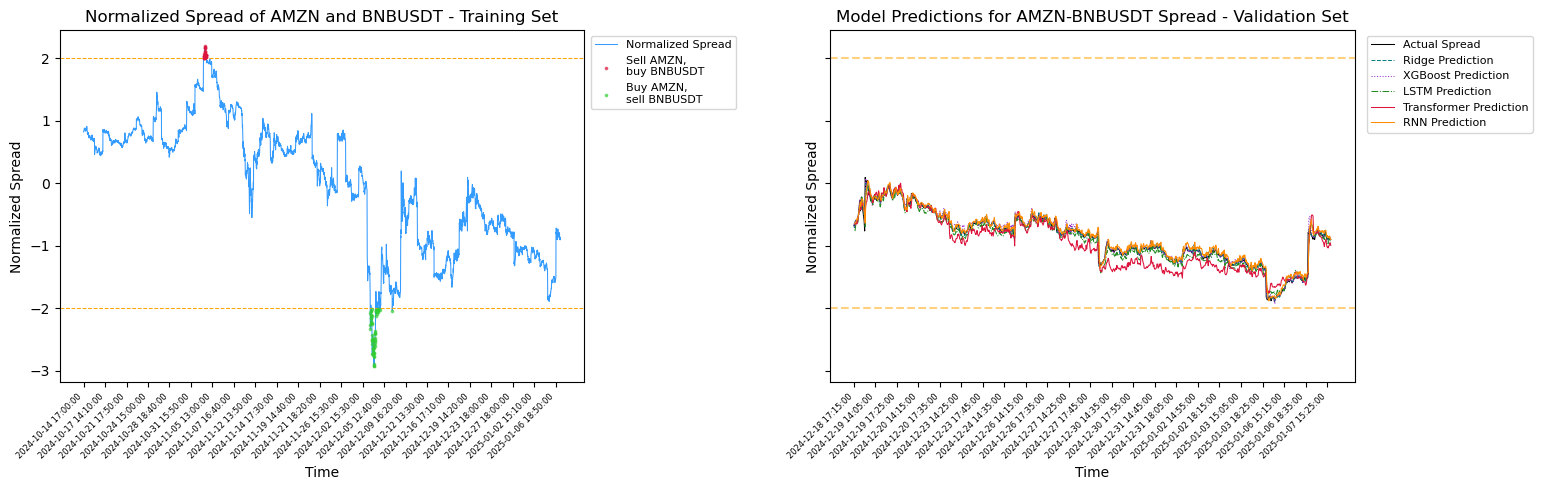

,AMZN_EMA8,AMZN_EMA21,AMZN_EMA55,AMZN_MACD,AMZN_RSI14,AMZN_BBupper,AMZN_BBmiddle,AMZN_BBlower,AMZN_ATR14,AMZN_StochK14,...,TRXUSDT_BBupper,TRXUSDT_BBmiddle,TRXUSDT_BBlower,TRXUSDT_ATR14,TRXUSDT_StochK14,TRXUSDT_StochD3,TRXUSDT_CCI20,TRXUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-1.391019,-1.376020,-1.345538,-0.474016,-1.382852,-1.406715,-1.372165,-1.329783,-1.308521,-1.394755,...,-1.003805,-1.021299,-1.022773,-0.397742,-1.078408,-1.169139,-1.046867,-0.670369,-1.405124,No action
2024-10-14 17:05:00,-1.393486,-1.378174,-1.347258,-0.484739,-1.308223,-1.408894,-1.374627,-1.332518,-1.365904,-1.500015,...,-1.003900,-1.021656,-1.023419,-0.405184,-0.997874,-1.113696,-0.903442,-0.670369,-1.403799,No action
2024-10-14 17:10:00,-1.395551,-1.380194,-1.348941,-0.490461,-1.329398,-1.412758,-1.377320,-1.334014,-1.425862,-1.502413,...,-1.003704,-1.022192,-1.024765,-0.397448,-0.997874,-1.058254,-1.291489,-1.410546,-1.404448,No action
2024-10-14 17:15:00,-1.395614,-1.381398,-1.350316,-0.473952,-0.918614,-1.418584,-1.379733,-1.332963,-1.418138,-1.276324,...,-1.003698,-1.022728,-1.025901,-0.404911,-1.266321,-1.122937,-1.119873,-1.410546,-1.397489,No action
2024-10-14 17:20:00,-1.397721,-1.383335,-1.351973,-0.479091,-1.242559,-1.421173,-1.381948,-1.334789,-1.387608,-1.315644,...,-1.003844,-1.023265,-1.026865,-0.411841,-1.534767,-1.307744,-0.997136,-1.410546,-1.406768,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.479e-01, tolerance: 4.435e-01
  model = cd_fast.enet_coordinate_descent(


Ridge Regression MSE: 0.0003695686698348647
XGBoost MSE: 0.0037897158816597174
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 
LSTM MSE: 0.0016248514333795465
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  
RNN MSE: 0.002217690785183254
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step 
Transformer MSE: 0.008989569477491207
[pypickle] Pickle file saved: [models/base_ridge_AMZN_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_AMZN_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_AMZN_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_AMZN_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_AMZN_TRXUSDT.pkl]


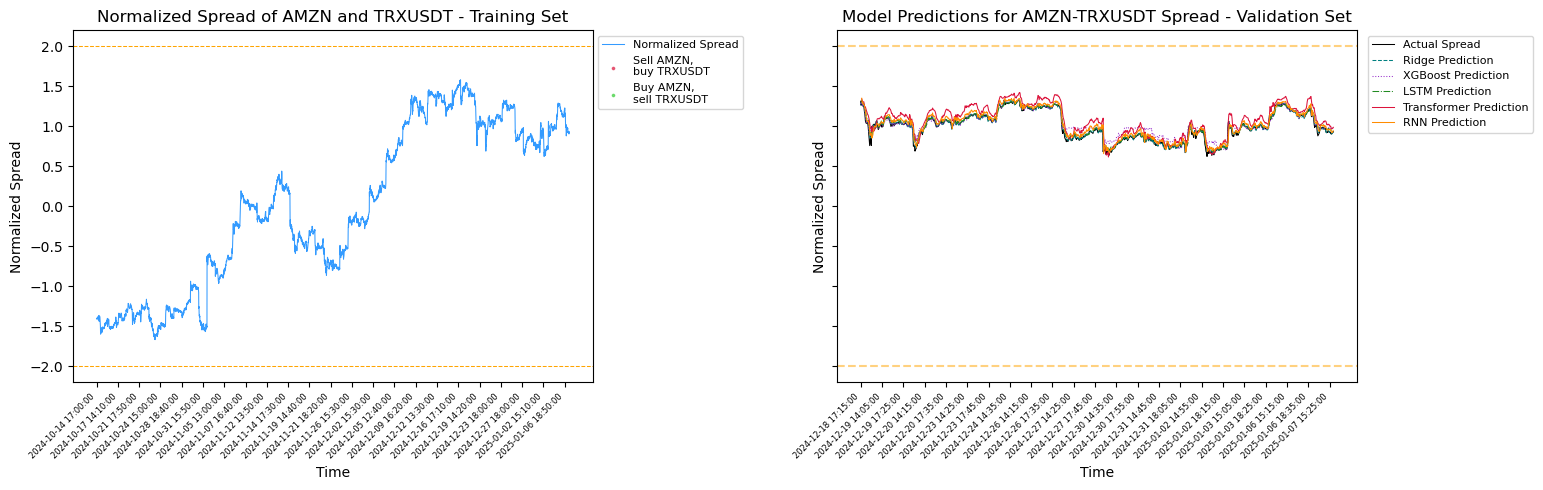

,SPY_ETF_EMA8,SPY_ETF_EMA21,SPY_ETF_EMA55,SPY_ETF_MACD,SPY_ETF_RSI14,SPY_ETF_BBupper,SPY_ETF_BBmiddle,SPY_ETF_BBlower,SPY_ETF_ATR14,SPY_ETF_StochK14,...,AVAXUSDT_BBupper,AVAXUSDT_BBmiddle,AVAXUSDT_BBlower,AVAXUSDT_ATR14,AVAXUSDT_StochK14,AVAXUSDT_StochD3,AVAXUSDT_CCI20,AVAXUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-0.821943,-0.826815,-0.863946,0.095464,0.157968,-0.938772,-0.815009,-0.684807,-1.050478,-0.861277,...,-0.864934,-0.848104,-0.823769,-0.675312,0.288677,-0.143438,-0.098890,0.719066,-0.157526,No action
2024-10-14 17:05:00,-0.817547,-0.824756,-0.861979,0.112251,0.604617,-0.937313,-0.814156,-0.684547,-1.002269,-0.544443,...,-0.868481,-0.849438,-0.822746,-0.712623,0.530194,0.250854,-0.095807,0.622665,-0.111415,No action
2024-10-14 17:10:00,-0.813803,-0.822750,-0.860030,0.125837,0.632310,-0.935771,-0.813230,-0.684224,-1.051632,0.315535,...,-0.871775,-0.850716,-0.821878,-0.739345,0.633701,0.499552,-0.166764,0.429861,-0.104548,No action
2024-10-14 17:15:00,-0.807646,-0.819595,-0.857620,0.154405,0.901345,-0.932689,-0.812509,-0.685772,-1.036958,1.030674,...,-0.874108,-0.852217,-0.822485,-0.708691,0.219672,0.475807,-0.742714,-0.437753,-0.057456,No action
2024-10-14 17:20:00,-0.802424,-0.816548,-0.855227,0.177393,0.936069,-0.928929,-0.811485,-0.687382,-1.081603,1.338456,...,-0.876644,-0.853662,-0.822762,-0.751542,-0.159854,0.238357,-0.677204,-0.437753,-0.053531,No action


Ridge Regression MSE: 0.01373858561636595
XGBoost MSE: 0.026568124989916935
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
LSTM MSE: 0.03823352054431727
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
RNN MSE: 0.0324664245292993
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
Transformer MSE: 0.05767077574227504
[pypickle] Pickle file saved: [models/base_ridge_SPY_ETF_AVAXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_SPY_ETF_AVAXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_SPY_ETF_AVAXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_SPY_ETF_AVAXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_SPY_ETF_AVAXUSDT.pkl]


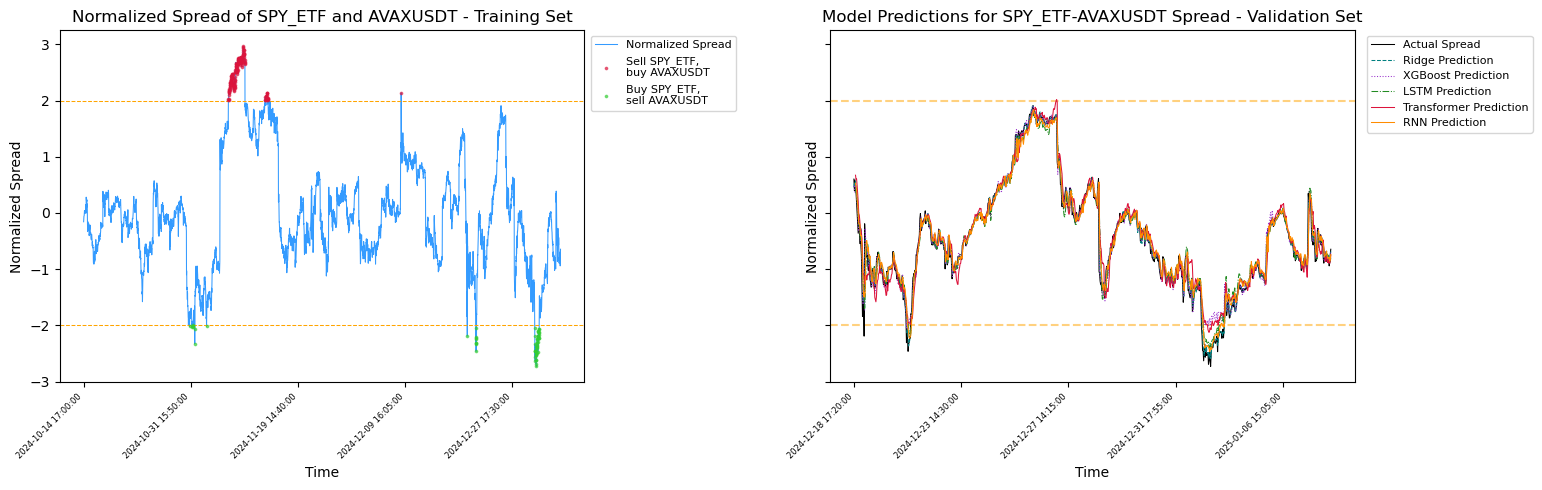

,SPY_ETF_EMA8,SPY_ETF_EMA21,SPY_ETF_EMA55,SPY_ETF_MACD,SPY_ETF_RSI14,SPY_ETF_BBupper,SPY_ETF_BBmiddle,SPY_ETF_BBlower,SPY_ETF_ATR14,SPY_ETF_StochK14,...,ETHUSDT_BBupper,ETHUSDT_BBmiddle,ETHUSDT_BBlower,ETHUSDT_ATR14,ETHUSDT_StochK14,ETHUSDT_StochD3,ETHUSDT_CCI20,ETHUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-14 17:00:00,-0.821943,-0.826815,-0.863946,0.095464,0.157968,-0.938772,-0.815009,-0.684807,-1.050478,-0.861277,...,-1.214199,-1.189273,-1.152963,-0.836899,-0.868914,-0.995396,-0.577529,-0.684591,1.205524,No action
2024-10-14 17:05:00,-0.817547,-0.824756,-0.861979,0.112251,0.604617,-0.937313,-0.814156,-0.684547,-1.002269,-0.544443,...,-1.216120,-1.190054,-1.152556,-0.823057,-0.612589,-0.839734,-0.041059,-0.140110,1.198483,No action
2024-10-14 17:10:00,-0.813803,-0.822750,-0.860030,0.125837,0.632310,-0.935771,-0.813230,-0.684224,-1.051632,0.315535,...,-1.217186,-1.190534,-1.152423,-0.866111,-0.324225,-0.623600,0.065176,-0.072814,1.197586,No action
2024-10-14 17:15:00,-0.807646,-0.819595,-0.857620,0.154405,0.901345,-0.932689,-0.812509,-0.685772,-1.036958,1.030674,...,-1.217698,-1.191029,-1.152896,-0.859142,-0.272297,-0.417576,-0.380903,-0.540824,1.204363,No action
2024-10-14 17:20:00,-0.802424,-0.816548,-0.855227,0.177393,0.936069,-0.928929,-0.811485,-0.687382,-1.081603,1.338456,...,-1.217873,-1.191235,-1.153133,-0.893167,-0.372838,-0.334785,-0.237298,-0.418468,1.202716,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.204e-01, tolerance: 4.444e-01
  model = cd_fast.enet_coordinate_descent(


Ridge Regression MSE: 0.0007288895632812315
XGBoost MSE: 0.0011523170832523056
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
LSTM MSE: 0.002105966329140685
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
RNN MSE: 0.0020745048498042777
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
Transformer MSE: 0.00871983409090366
[pypickle] Pickle file saved: [models/base_ridge_SPY_ETF_ETHUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_SPY_ETF_ETHUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_SPY_ETF_ETHUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_SPY_ETF_ETHUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_SPY_ETF_ETHUSDT.pkl]


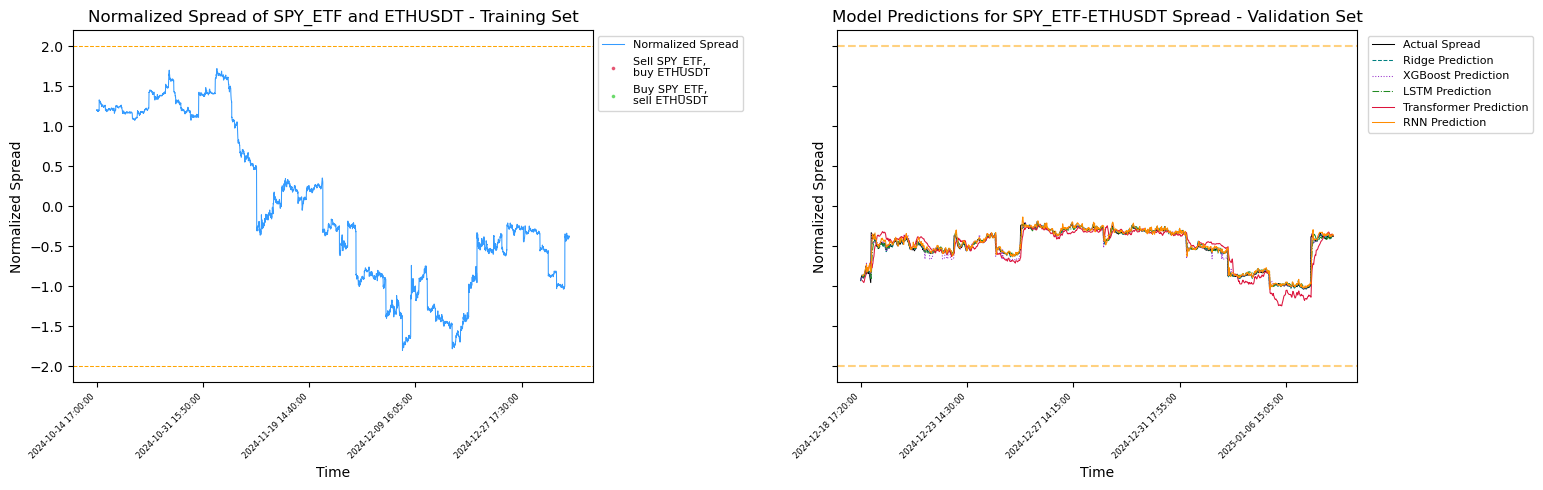

,EQQQ_ETF_EMA8,EQQQ_ETF_EMA21,EQQQ_ETF_EMA55,EQQQ_ETF_MACD,EQQQ_ETF_RSI14,EQQQ_ETF_BBupper,EQQQ_ETF_BBmiddle,EQQQ_ETF_BBlower,EQQQ_ETF_ATR14,EQQQ_ETF_StochK14,...,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,BNBUSDT_StochD3,BNBUSDT_CCI20,BNBUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-31 13:40:00,-2.421369,-2.359066,-2.286300,-0.917897,-0.882027,-2.234270,-2.324478,-2.382582,0.939460,-1.357598,...,-1.776531,-1.711959,-1.611875,-0.946220,0.903649,0.516372,0.882182,1.225796,-2.478167,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 13:45:00,-2.435985,-2.369627,-2.292054,-0.984888,-1.104786,-2.249224,-2.338676,-2.395838,0.958088,-1.439556,...,-1.771578,-1.710109,-1.613285,-0.963566,1.280202,0.924325,1.053383,1.225796,-2.518491,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 13:50:00,-2.447920,-2.379460,-2.297693,-1.031632,-1.119474,-2.265577,-2.352450,-2.406870,0.731855,-1.439556,...,-1.765701,-1.708064,-1.615262,-0.987518,1.318220,1.204598,1.125765,1.225796,-2.521504,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 14:00:00,-2.449639,-2.385311,-2.301920,-1.008951,-0.789030,-2.286321,-2.364401,-2.409943,0.736321,-1.335259,...,-1.762715,-1.706993,-1.616201,-1.009760,1.228360,1.316311,0.825610,0.975192,-2.485700,"Buy EQQQ_ETF, sell BNBUSDT"
2024-10-31 14:05:00,-2.448141,-2.389470,-2.305543,-0.962965,-0.668818,-2.319364,-2.377455,-2.403005,0.595508,-1.011599,...,-1.763332,-1.707285,-1.616150,-0.975496,0.891388,1.182545,0.239439,0.286030,-2.471432,"Buy EQQQ_ETF, sell BNBUSDT"


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.892e-01, tolerance: 2.646e-01
  model = cd_fast.enet_coordinate_descent(


Ridge Regression MSE: 0.0005946804114386311
XGBoost MSE: 0.005155259605027899
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step 
LSTM MSE: 0.003711590271957912
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
RNN MSE: 0.0027932814555162886
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
Transformer MSE: 0.010917581017838091
[pypickle] Pickle file saved: [models/base_ridge_EQQQ_ETF_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_EQQQ_ETF_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_EQQQ_ETF_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_EQQQ_ETF_BNBUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_EQQQ_ETF_BNBUSDT.pkl]


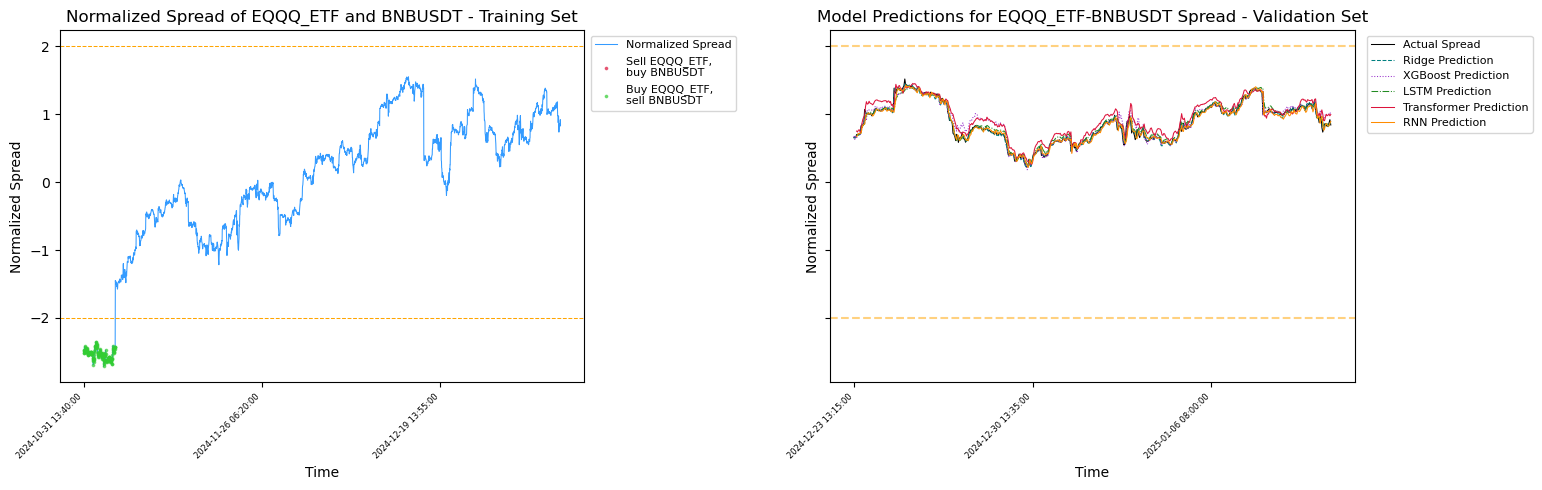

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,ADAUSDT_BBupper,ADAUSDT_BBmiddle,ADAUSDT_BBlower,ADAUSDT_ATR14,ADAUSDT_StochK14,ADAUSDT_StochD3,ADAUSDT_CCI20,ADAUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.170352,-1.165995,-1.160889,-0.951622,1.308670,0.592696,1.456019,1.365633,-1.529669,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.169088,-1.165624,-1.161437,-0.936036,1.485379,1.187456,1.842159,1.365633,-1.519034,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.168000,-1.165159,-1.161615,-0.950474,1.485379,1.477211,1.640494,1.365633,-1.515485,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.167815,-1.164958,-1.161396,-0.910191,1.090238,1.401807,0.446487,0.275851,-1.526110,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.167767,-1.164865,-1.161257,-0.909955,0.553975,1.080281,0.018030,-0.113357,-1.529651,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+00, tolerance: 2.730e+00
  model = cd_fast.enet_coordinate_descent(


Ridge Regression MSE: 0.00015980424284292162
XGBoost MSE: 0.0003279232183944242
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
LSTM MSE: 0.0017610394217526892
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
RNN MSE: 0.0004921290663028004
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
Transformer MSE: 0.0009377076969117187
[pypickle] Pickle file saved: [models/base_ridge_BNBUSDT_ADAUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_BNBUSDT_ADAUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_BNBUSDT_ADAUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_BNBUSDT_ADAUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_BNBUSDT_ADAUSDT.pkl]


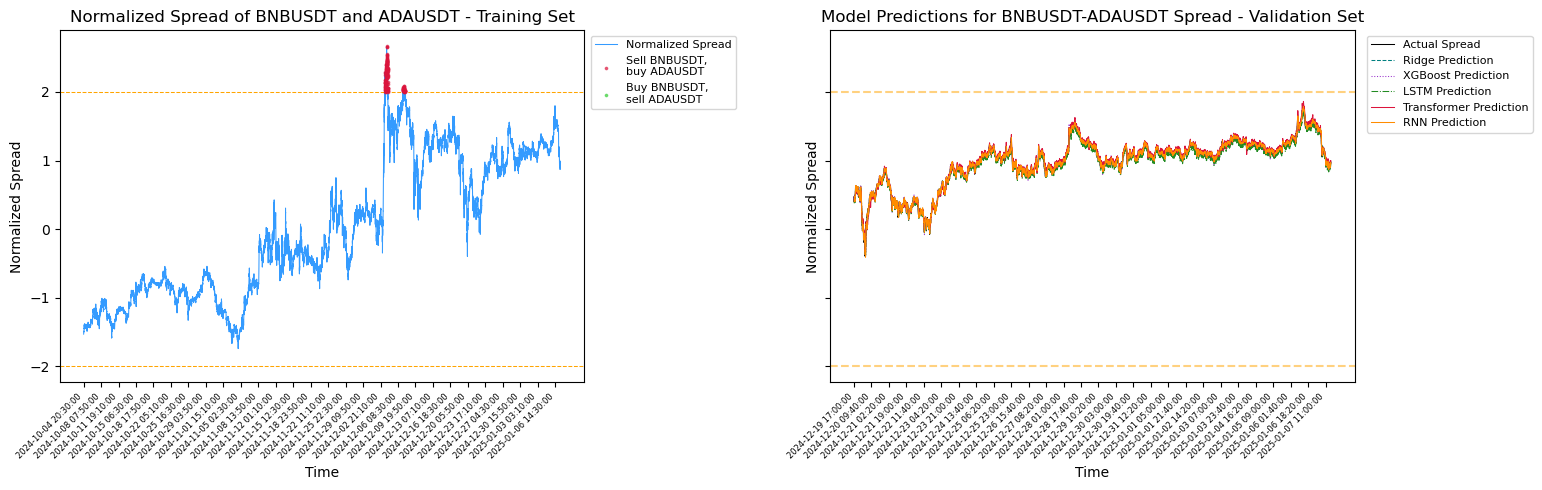

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,BTCUSDT_BBupper,BTCUSDT_BBmiddle,BTCUSDT_BBlower,BTCUSDT_ATR14,BTCUSDT_StochK14,BTCUSDT_StochD3,BTCUSDT_CCI20,BTCUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.618731,-1.610621,-1.601708,-1.075696,1.104313,0.193947,0.955025,1.329005,1.606202,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.617758,-1.609975,-1.601395,-1.066323,1.440182,0.951930,1.340293,1.329005,1.603632,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.617209,-1.609234,-1.600459,-1.101918,1.440182,1.374378,1.315355,1.329005,1.603382,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.616920,-1.608707,-1.599692,-1.105290,1.290407,1.438567,0.859992,0.914392,1.605177,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.616693,-1.608364,-1.599232,-1.120546,1.043253,1.301656,0.554197,0.644823,1.606358,No action


Ridge Regression MSE: 4.581584533145013e-05
XGBoost MSE: 9.890036375907893e-05
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
LSTM MSE: 0.0002417169661845504
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
RNN MSE: 0.0004432548910262044
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
Transformer MSE: 0.0009938044570864803
[pypickle] Pickle file saved: [models/base_ridge_BNBUSDT_BTCUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_BNBUSDT_BTCUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_BNBUSDT_BTCUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_BNBUSDT_BTCUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_BNBUSDT_BTCUSDT.pkl]


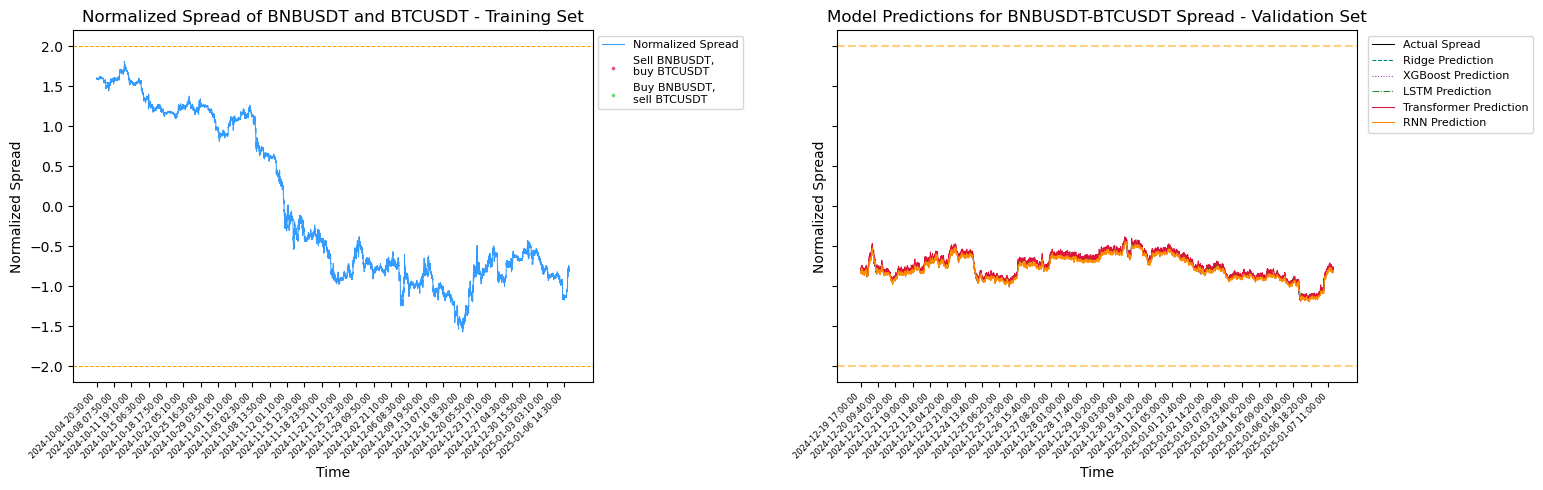

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,TRXUSDT_BBupper,TRXUSDT_BBmiddle,TRXUSDT_BBlower,TRXUSDT_ATR14,TRXUSDT_StochK14,TRXUSDT_StochD3,TRXUSDT_CCI20,TRXUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.054722,-1.061994,-1.067222,-0.426393,-0.209515,-0.683981,-0.681322,-0.367330,-1.528881,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.054852,-1.062087,-1.067275,-0.423538,-0.015881,-0.283463,-0.152442,0.162034,-1.518278,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.055008,-1.062272,-1.067490,-0.420888,-0.209515,-0.149958,-0.623758,-0.367330,-1.514741,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.055034,-1.062364,-1.067652,-0.432816,-0.209515,-0.149958,-0.580148,-0.367330,-1.525346,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.055227,-1.062549,-1.067829,-0.443892,-0.306332,-0.250087,-0.525799,-0.102648,-1.528881,No action


Ridge Regression MSE: 0.00015862503376715505
XGBoost MSE: 0.00039124032073265983
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
LSTM MSE: 0.0012178057662455557
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
RNN MSE: 0.0009049783522954769
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step   
Transformer MSE: 0.0035059674498237096
[pypickle] Pickle file saved: [models/base_ridge_BNBUSDT_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_BNBUSDT_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_BNBUSDT_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_BNBUSDT_TRXUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_BNBUSDT_TRXUSDT.pkl]


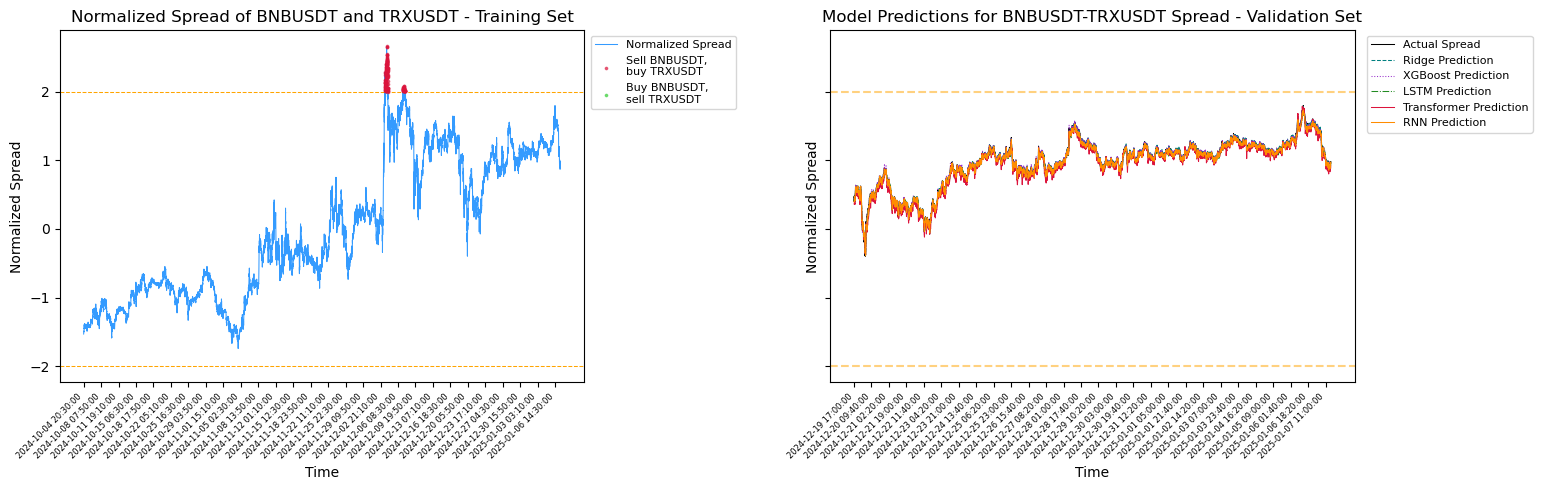

,BNBUSDT_EMA8,BNBUSDT_EMA21,BNBUSDT_EMA55,BNBUSDT_MACD,BNBUSDT_RSI14,BNBUSDT_BBupper,BNBUSDT_BBmiddle,BNBUSDT_BBlower,BNBUSDT_ATR14,BNBUSDT_StochK14,...,XRPUSDT_BBupper,XRPUSDT_BBmiddle,XRPUSDT_BBlower,XRPUSDT_ATR14,XRPUSDT_StochK14,XRPUSDT_StochD3,XRPUSDT_CCI20,XRPUSDT_WILLR14,NormalizedSpread,TradingSignal
OpenTime,,,,,,,,,,,,,,,,,,,,,
2024-10-04 20:30:00,-1.549877,-1.556473,-1.542531,0.010369,1.327634,-1.575123,-1.565233,-1.551071,-0.859950,1.415713,...,-1.043663,-1.040717,-1.037247,-0.817933,0.972741,0.243749,0.908459,1.345288,-1.534199,No action
2024-10-04 20:35:00,-1.542836,-1.553019,-1.541699,0.125173,1.668612,-1.566268,-1.562052,-1.553735,-0.828814,1.415713,...,-1.043402,-1.040591,-1.037259,-0.819008,1.323922,0.898844,1.089337,1.345288,-1.523464,No action
2024-10-04 20:40:00,-1.536575,-1.549558,-1.540770,0.224898,1.773385,-1.558807,-1.558430,-1.554071,-0.854715,1.415713,...,-1.043172,-1.040482,-1.037275,-0.826779,1.464394,1.299180,0.969691,1.345288,-1.519884,No action
2024-10-04 20:45:00,-1.534060,-1.547376,-1.540254,0.265662,1.082272,-1.554550,-1.555868,-1.553260,-0.823952,1.233995,...,-1.043135,-1.040464,-1.037276,-0.822143,1.241614,1.392061,0.451953,0.731344,-1.530613,No action
2024-10-04 20:50:00,-1.532890,-1.545713,-1.539882,0.282772,0.869689,-1.551331,-1.553836,-1.552453,-0.850201,0.991706,...,-1.043173,-1.040488,-1.037286,-0.819532,0.827879,1.220705,0.044865,0.205105,-1.534183,No action


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.078e+00, tolerance: 2.730e+00
  model = cd_fast.enet_coordinate_descent(


Ridge Regression MSE: 0.00016669478239243684
XGBoost MSE: 0.0003133097939807768
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
LSTM MSE: 0.0017447249693072773
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step   
RNN MSE: 0.0005411232557975744
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step   
Transformer MSE: 0.0010030318695374602
[pypickle] Pickle file saved: [models/base_ridge_BNBUSDT_XRPUSDT.pkl]
[pypickle] Pickle file saved: [models/base_xgb_BNBUSDT_XRPUSDT.pkl]
[pypickle] Pickle file saved: [models/base_lstm_BNBUSDT_XRPUSDT.pkl]
[pypickle] Pickle file saved: [models/base_rnn_BNBUSDT_XRPUSDT.pkl]
[pypickle] Pickle file saved: [models/base_transformer_BNBUSDT_XRPUSDT.pkl]


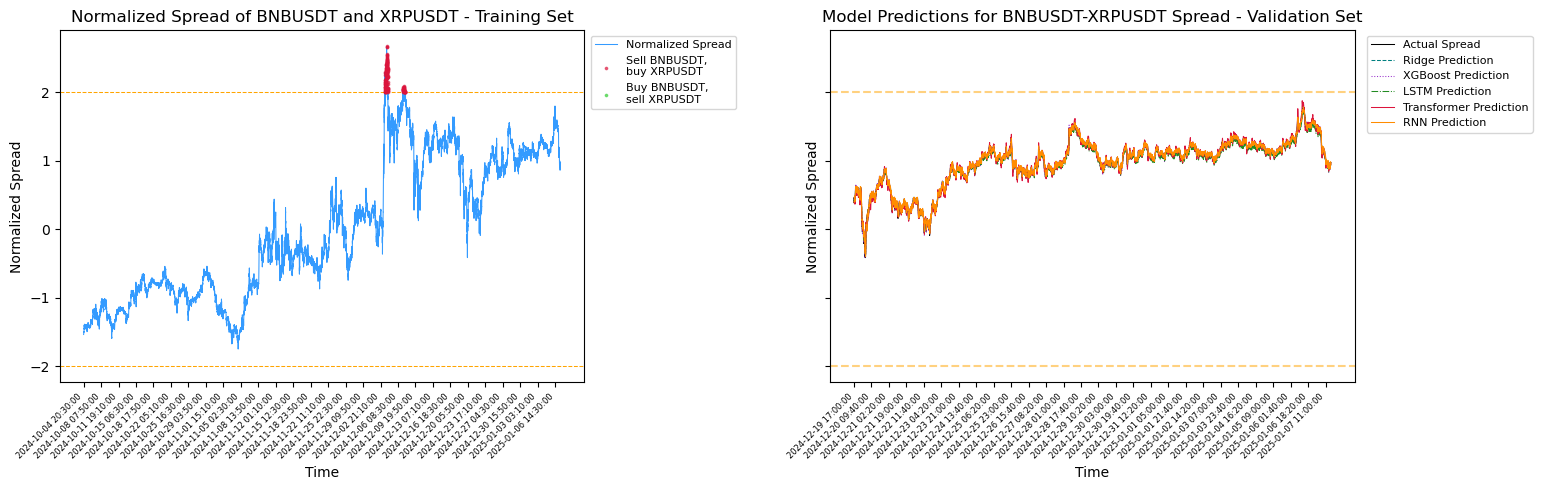

Pair,META DAXEX_ETF,AMZN BNBUSDT,AMZN TRXUSDT,SPY_ETF AVAXUSDT,SPY_ETF ETHUSDT,EQQQ_ETF BNBUSDT,BNBUSDT ADAUSDT,BNBUSDT BTCUSDT,BNBUSDT TRXUSDT,BNBUSDT XRPUSDT
Ridge MSE,0.002669,0.001170,0.000370,0.013739,0.000729,0.000595,0.000160,0.000046,0.000159,0.000167
Ridge Training Time,0.008631,0.002868,0.004268,0.003124,0.002575,0.004154,0.004057,0.008094,0.004784,0.004441
Ridge Memory Usage,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
XGB MSE,0.011973,0.001935,0.003790,0.026568,0.001152,0.005155,0.000328,0.000099,0.000391,0.000313
XGB Training Time,0.201406,0.208403,0.147964,0.276656,0.160370,0.177794,0.281629,0.195019,0.222804,0.252858
XGB Memory Usage,0.000000,0.257812,0.257812,0.000000,0.000000,0.257812,1.289062,0.515625,0.257812,1.031250
LSTM MSE,0.025824,0.006432,0.001625,0.038234,0.002106,0.003712,0.001761,0.000242,0.001218,0.001745
LSTM Training Time,19.383624,59.090014,59.688234,60.624838,60.685087,36.832829,394.748942,372.632068,349.575781,337.324766
LSTM Memory Usage,13.265625,26.820312,9.324219,-82.507812,13.472656,12.542969,-67.160156,-15.078125,-19.820312,-16.312500
RNN MSE,0.020873,0.005054,0.002218,0.032466,0.002075,0.002793,0.000492,0.000443,0.000905,0.000541


In [6]:
# Ensure that we can overwrite the models
# Delete all files starting with "base_" in models folder
base_files = glob.glob('models/base_*')
for file in base_files:
    try:
        os.remove(file)
    except Exception as e:
        print(f'Error deleting {file}: {str(e)}')

untuned_performance = []
scalers = []
validation_dfs = pd.DataFrame()
s = 2.0

# Define configuration for Technical Analysis feature engineering
config = {
    'ema': [8, 21, 55],
    'macd': {
        'fast': 12,
        'slow': 26,
        'signal': 9,
    },
    'rsi': [14],
    'bb': {
        'timeperiod': 20,
        'nbdevup': 2,
        'nbdevdn': 2,
    },
    'atr': {
        'timeperiod': 14,
    },
    'stoch': {
        'fastk_period': 14,
        'slowk_period': 3,
        'slowd_period': 3,
    },
    'cci': {
        'timeperiod': 20,
    },
    'willr': {
        'timeperiod': 14,
    },
}

for p in pairs:
    tickerX, tickerY = p.split(' ')
    spread_df = create_features(tickerX, tickerY,
                                df_full[df_full['Symbol']==tickerX],
                                df_full[df_full['Symbol']==tickerY],
                                config=config,
                                dropna=True)
    spread_df, scaler = normalize_features(spread_df)
    spread_df = spread_df.rename(columns={'Spread':'NormalizedSpread'})
    # Save scaler for test set
    scalers.append({p:scaler})

    # ADD LASSO FEATURE SELECTION

    # Generate trading signals based on spreads
    spread_df.loc[:, 'TradingSignal'] = 'No action'
    spread_df.loc[spread_df['NormalizedSpread'] < -1*s, 'TradingSignal']= f'Buy {tickerX}, sell {tickerY}'
    spread_df.loc[spread_df['NormalizedSpread'] > s, 'TradingSignal'] = f'Buy {tickerY}, sell {tickerX}'

    # Preview the data
    display(spread_df.head())
    # Added .copy() to avoid warnings
    model_df = spread_df.drop(['TradingSignal'], axis=1).copy()

    # Create 5 lags
    # To be replaced with/extended by Technical Analysis features
    for lag in range(1, 6):
        model_df.loc[:, f'NormalizedSpread_Lag{lag}'] = model_df['NormalizedSpread'].shift(lag)
    model_df = model_df.dropna()

    # Perform LASSO feature selection
    X_temp = model_df.drop('NormalizedSpread', axis=1)
    y_temp = model_df['NormalizedSpread']
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_temp, y_temp)
    # Get selected features based on non-zero coefficients
    selected_features = X_temp.columns[abs(lasso.coef_) > 0].tolist()
    model_df = pd.concat([X_temp[selected_features], y_temp], axis=1)

    # Models with default parameters
    (ridge, ridge_mse, ridge_test_df,
     ridge_time, ridge_memory) = models.ridge_regression(df=model_df, p=p)
    (xgb, xgb_mse, xgb_test_df,
     xgb_time, xgb_memory) = models.xgboost_regression(df=model_df, p=p)
    (lstm, lstm_mse, lstm_test_df,
     lstm_time, lstm_memory) = models.lstm_regression(df=model_df, p=p)
    (rnn, rnn_mse, rnn_test_df,
     rnn_time, rnn_memory) = models.rnn_regression(df=model_df, p=p)
    (trf, trf_mse, trf_test_df,
     trf_time, trf_memory) = models.transformer_regression(df=model_df, p=p)

    # Save the models
    pypickle.save(f'models/base_ridge_{p.replace(" ", "_")}.pkl', ridge)
    pypickle.save(f'models/base_xgb_{p.replace(" ", "_")}.pkl', xgb)
    pypickle.save(f'models/base_lstm_{p.replace(" ", "_")}.pkl', lstm)
    pypickle.save(f'models/base_rnn_{p.replace(" ", "_")}.pkl', rnn)
    pypickle.save(f'models/base_transformer_{p.replace(" ", "_")}.pkl', trf)

    validation_dfs = pd.concat([validation_dfs,
                                ridge_test_df,
                                xgb_test_df,
                                lstm_test_df,
                                rnn_test_df,
                                trf_test_df,
                                ])

    untuned_performance.append({'Pair': p,
                                'Ridge MSE': ridge_mse,
                                'Ridge Training Time': ridge_time,
                                'Ridge Memory Usage': ridge_memory,
                                'XGB MSE': xgb_mse,
                                'XGB Training Time': xgb_time,
                                'XGB Memory Usage': xgb_memory,
                                'LSTM MSE': lstm_mse,
                                'LSTM Training Time': lstm_time,
                                'LSTM Memory Usage': lstm_memory,
                                'RNN MSE': rnn_mse,
                                'RNN Training Time': rnn_time,
                                'RNN Memory Usage': rnn_memory,
                                'Transformer MSE': trf_mse,
                                'Transformer Training Time': trf_time,
                                'Transformer Memory Usage': trf_memory,
                                })
    # Plot forecasts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
    data.plot_spread(spread_df, tickerX, tickerY, ax=ax1)
    models.plot_model_forecasts(ridge_test_df, xgb_test_df,
                                lstm_test_df, trf_test_df,
                                rnn_test_df, tickerX, tickerY, ax=ax2)
    plt.show();
    # spread_df.to_csv(f'output/spread_{tickerX}_{tickerY}.csv')

untuned_performance_df = pd.DataFrame(untuned_performance).set_index('Pair').T
display(untuned_performance_df)

The above table shows the validation set metrics: MSE, time usage and memory usage.

The below listing shows the average metrics for the entire baseline pair trading portfolio.

In [7]:
display(untuned_performance_df.mean(axis=1))

Ridge MSE                      0.001980
Ridge Training Time            0.004700
Ridge Memory Usage             0.000000
XGB MSE                        0.005170
XGB Training Time              0.212490
XGB Memory Usage               0.386719
LSTM MSE                       0.008290
LSTM Training Time           175.058618
LSTM Memory Usage            -12.545312
RNN MSE                        0.006786
RNN Training Time            103.582446
RNN Memory Usage               7.258984
Transformer MSE                0.016542
Transformer Training Time    207.751314
Transformer Memory Usage      32.391016
dtype: float64

In [ ]:
validation_dfs = validation_dfs.reset_index(drop=True)

for model in validation_dfs['Model'].unique().tolist():
    model_df = validation_dfs[validation_dfs['Model']==model]
    performance = strategy.run_strategy(model_df)
    print(f'\n{model} Model Performance:')
    for metric, value in performance.items():
        if metric not in ['Portfolio Values', 'Daily Returns']:
            print(f'{metric}: {value:.4f}')
    log.info(f'Portfolio metrics for model {model} calculated correctly.')